<a href="https://colab.research.google.com/github/shazoop/EE290/blob/master/HW1_MRI1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magnetic Resonance Imaging (MRI) I (Sparsity)

## Looking Ahead

In the lecture, we discussed how signal acquisition in an MRI system leads to a (potentially underdetermined) system of linear equations relating the observations to the unknown target signal (e.g., an image of a cross section of part of a patient's body). 

This notebook will explore another key aspect of this acquisition scenario: *in a certain basis, the target signal is sparse*. This will allow us, in later notebooks, to apply methods from compressed sensing to the recovery of these data from undersampled measurements.

As we saw in the homework and in the textbook, MRI data are acquired in the frequency domain. To analyze the corresponding spatial profile (and its transform-domain sparsity), we will need to perform some signal processing after we download the data. We are using anatomical data from the BOLD5000 dataset: a functional MRI dataset consisting of subjects' brain scans taken while they are observing various images from the ImageNet, SUN, and COCO datasets. In this notebook, we will not analyze any functional data, though. The data are publicly available; more information can be found at the website [here](https://bold5000.github.io/).

## Getting the Data and Setting Up

We use the AWS S3 protocol to download a certain subset of the data, corresponding to one subject's anatomical data. For more information on the dataset, see [here](https://openneuro.org/datasets/ds001499/versions/1.3.0) and the BOLD5000 paper on the official website linked above.



### Install AWS Command Line Utilities
These utilities let us download the dataset. 

**Note**: You may need to restart the notebook session after you download awscli below, per a warning message I get from Colab; things may also work fine if you skip the restart, though.

In [1]:
## Install AWS CLI tools
!pip install awscli
## Prepare data directory
import os
os.chdir('/content')
!mkdir bold5000
os.chdir('/content/bold5000')

     |████████████████████████████████| 2.1MB 2.9MB/s 
     |████████████████████████████████| 51kB 25.7MB/s 
     |████████████████████████████████| 5.7MB 42.1MB/s 
  Found existing installation: rsa 4.0
    Uninstalling rsa-4.0:
      Successfully uninstalled rsa-4.0
  Found existing installation: botocore 1.12.224
    Uninstalling botocore-1.12.224:
      Successfully uninstalled botocore-1.12.224


### Download the Anatomical Data

We download the (anonymized) anatomical data from the third subject in the BOLD5000 dataset.

In [2]:
## Grab the data
#!aws s3 sync --no-sign-request --exclude "*" --include "*06*" s3://openneuro.org/ds001499/derivatives/fmriprep/sub-CSI3/ses-13/func/ /content/bold5000/sub-CSI3_ses-13_run-06/
!aws s3 sync --no-sign-request s3://openneuro.org/ds001499/sub-CSI3/ses-16/anat/ /content/bold5000/sub-CSI3_anat/

download: s3://openneuro.org/ds001499/sub-CSI3/ses-16/anat/tmp_dcm2bids/log/sub-CSI3_20180607T112621.log to sub-CSI3_anat/tmp_dcm2bids/log/sub-CSI3_20180607T112621.log
download: s3://openneuro.org/ds001499/sub-CSI3/ses-16/anat/sub-CSI3_ses-16_T1w.json to sub-CSI3_anat/sub-CSI3_ses-16_T1w.json
download: s3://openneuro.org/ds001499/sub-CSI3/ses-16/anat/sub-CSI3_ses-16_T1w.nii.gz to sub-CSI3_anat/sub-CSI3_ses-16_T1w.nii.gz


### Auxiliary definitions

We will use these functions throughout the demo. They consist of a helper function for plotting images in a format similar to MATLAB, and a few wrappers for the wavelet transforms we will use throughout to hide some of the unimportant implementation details. More on the latter below.

In [0]:
## Auxiliary code for our wavelet experiments
import bokeh
import bokeh.plotting as bpl
from bokeh.models import ColorBar, BasicTicker, LinearColorMapper
import pywt

## Try to do something like imagesc in MATLAB using Bokeh tools.
def imagesc(M, title=''):
  m, n = M.shape
  
  # 600 px should be good; calculate ph to try to get aspect ratio right
  pw = 600
  ph = round(1.0 * pw * m / n)
  h = bpl.figure(plot_width = pw, plot_height = ph, x_range=(0, 1.0*n),
                 y_range=(0, 1.0*m), toolbar_location='below',
                 title=title, match_aspect=True
                )
  
  minval = np.min(M)
  maxval = np.max(M)
  
  color_mapper = LinearColorMapper(palette="Greys256", low=minval, high=maxval)
  h.image(image=[M], x=0, y=0, dw=1.0*n, dh=1.0*m, color_mapper=color_mapper)
  
  color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                      label_standoff=12, border_line_color=None, location=(0, 0))
  
  h.add_layout(color_bar, 'right')
  

  bpl.show(h)
  return h
  
## Standard basis element function for matrix space (ZERO-INDEXED)
def stdbel(n, i, j):
  E = np.zeros((n, n))
  E[i, j] = 1
  return E

## Wavelet functions below
## Note: we expect all image sizes to be powers-of-two and square!
## So if you adapt this code, be sure to fix this or enforce this requirement...

# Get a default slice object for a multilevel wavelet transform
# Used to abstract this annoying notation out of the transform...
def default_slices(levels, n):
  c = pywt.wavedec2(np.zeros((n, n)), 'db4', mode='periodization', level=levels)
  bye, slices = pywt.coeffs_to_array(c)
  return slices

# Wrapper for forward discrete wavelet transform
# Output data as a matrix (we don't care about tuple format)
def dwt(levels, sdom_data):
  c = pywt.wavedec2(sdom_data, 'db4', mode='periodization', level=levels)
  output, bye = pywt.coeffs_to_array(c)
  return output

# Wrapper for inverse discrete wavelet transform
# Expect wdom_data as a matrix (we don't care about tuple format)
def idwt(levels, wdom_data, slices=None):
  n = wdom_data.shape[0]
  if slices is None:
    slices = default_slices(levels, n)
  c = pywt.array_to_coeffs(wdom_data, slices, output_format='wavedec2')
  return pywt.waverec2(c, 'db4', mode='periodization')

## Visualizing the Data

The MR machine (Siemens 3T Verio) automatically applies inverse Fourier transforms to the measured slice data, so when we perform visualization below it is of the spatial domain data.

We then take a look at the data cube we have loaded from several angles. We use the [nibabel](http://nipy.org/nibabel/) MRI data processing library to easily extract the image data from the T1w scan file.



In [4]:
## Have a look at the data
import numpy as np
import nibabel as nib

img = nib.load('/content/bold5000/sub-CSI3_anat/sub-CSI3_ses-16_T1w.nii.gz')

data = img.get_fdata()
hdr = img.header

## Check the data shape and units
print("Data shape: {}".format(data.shape))

Data shape: (176, 256, 256)


The dataset consists of a 3D array. Think of the three dimensions as sampled spatial coordinates (x, y, z). How is the coordinate system enforced by the MR scanner oriented? We plot a "halfway" slice for each of the three possible axis-aligned plane orientations to find out.

In [0]:
## Store dimensions
Nx = data.shape[0]
Ny = data.shape[1]
Nz = data.shape[2]

In [6]:
### x slice
bpl.output_notebook()

imagesc(data[Nx//2, :, :], title='Slicing orthogonal to x-axis')

Figure(id='1002', ...)

In [7]:
### y slice
bpl.output_notebook()
imagesc(data[:, Ny//2, :], title='Slicing orthogonal to y-axis')

Figure(id='1113', ...)

In [8]:
### z slice
bpl.output_notebook()
imagesc(data[:, :, round(0.6*Nz)], title='Slicing orthogonal to z-axis')

Figure(id='1233', ...)

We infer that the y axis is parallel to the subject's "line of sight"; the z axis is parallel to the direction of gravity, if the subject were standing upright; and the x axis occupies the remaining orthogonal direction. In practice, the x direction is called the *sagittal axis*; the MR system acquires the 3D data cube by collecting several 2D scans along the sagittal axis by the process we described in the homework handout.

## Wavelet Sparsity of the Data

Natural images, like the spatial domain sagittal MRI slices that our MR system acquires (post-Fourier-transformation), can often be represented concisely in a 2D Wavelet basis. We will see in later lectures/homeworks how this makes the techniques of compressed sensing applicable. For now, we will investigate empirically the transform-domain sparsity of a representative sagittal slice of our MR data.

### Fixing our Slice

We choose the sagittal slice we plotted above.

In [0]:
X = data[Nx//2, :, :];

### Loading and Viewing Wavelet Basis Vectors

We choose to represent our image in a db4 ([Daubechies](https://en.wikipedia.org/wiki/Ingrid_Daubechies) 4) wavelet basis, with a 2-level wavelet transformation (more on that below). In code, where we are interested in efficient computation of these transformations, we do not have direct access to the (inefficient-to-use) basis vectors themselves. But we can generate their spatial-domain representations by the pseudocode

``` w_i = inverse_wavelet_transform(e_i) ```,

where `w_i` represents the `i`-th wavelet basis function and `e_i` represents the `i`-th standard basis element. In this case, these standard basis elements are matrices with a 1 in the `i`-th position and zeros otherwise, where `i` runs from `1` up to `mn`; here our data are square, and `m = n = 256`. Be sure you understand the logic here---it is a good chance to refresh your understanding of linear algebra, if you need to do so!

Below, we examine some of the wavelet basis functions. We use the implementation provided by [pywavelet](https://pywavelets.readthedocs.io/en/latest/). **Note**: it is essential here to set the ``mode = periodization`` wavelet transformation option in order to have the `dwt2` and `idwt2` functions behave (as-is) as linear operators on the space of matrices with dimensions equal to those of our input slice; we have made sure to do this in our pre-defined wrappers to these transforms.

In [10]:
## Examine a one-layer wavelet decomposition basis function.
bpl.output_notebook()

n = Nz
levels = 1  # Change this to set the number of recursive wavelet transforms to use.

I = 50
J = 13  # Change these to view other basis elements. Must have 0 <= I, J <= n-1

E = stdbel(n, I, J)
F = idwt(levels, E)
imagesc(F)
print('Frobenius norm of F: {}'.format(np.linalg.norm(F, ord='fro')))

Frobenius norm of F: 1.0


Our check on the norm of `F` shows that the inverse transform has proper normalization here (unlike, for example, in the standard convention for FFT algorithms), so that the wavelet transform is indeed unitary.

Be sure to zoom in to the part of the image above that is nonzero, to get a better sense of what the wavelet motif is. You may also try entering different indices above to view different basis elements. The wavelet basis functions have the interesting property of being very localized in time--their support is quite small. This makes them good at concisely representing edges in natural images.

We will examine one other thing: the Fourier transform of the above wavelet basis element.


In [11]:
## Examine the 2D Fourier magnitudes of the above wavelet basis element
bpl.output_notebook()

F_Fourier = np.fft.fft2(F, norm='ortho')
imagesc(np.fft.fftshift(np.absolute(F_Fourier)),
        title='Fourier magnitudes of wavelet basis vector')

Figure(id='1497', ...)

Intriguingly, this basis element is also localized in frequency: points in the above figure that are black represent points where the 2D Fourier transform of the basis element is very close to zero, showing that it has (approximately) compact support! This property of being time-and-frequency-localized simultaneously is characteristic of wavelet basis elements.

**Note**: Computational FFT methods return the Fourier transform on the square `[0, 1]^2`; recall that the 2D FFT is 1-periodic in each of its two normalized spatial variables independently. This implies that the low-frequency content of the signal is located in the "corners" of the raw Fourier transform magnitude estimate obtained; the plot above applies the `fftshift` function, which effectively transforms the domain to `[-0.5, +0.5]^2` and puts low frequencies in the center of the plot.

### Studying the Wavelet Transform of our MR Image

Now we apply the wavelet transform we used above to our MR slice.

In [12]:
bpl.output_notebook()
levels = 2
W = dwt(levels, X)
imagesc(W, '{}-level wavelet transform of MR image'.format(levels))

Figure(id='1644', ...)

The original image can be located in the bottom-left (by default) of the transformed result. Play around with the `levels` variable set above (set it to 1, 2, 3, maybe more...) to see the recursive nature of the discrete wavelet transform: a single level of the transform turns the input image into four new versions (LL, LH, HL, HH, from left-to-right and bottom-to-top) that contain information about the image at different resolutions, and further levels recurse on the LL level of the previous level. For more on this, see the description in the course notes.

The wavelet transform is an orthonormal transform, and the above image suggests it indeed does a good job of sparsely representing the original MR image: lots of coefficients above appear to be zero! You will investigate this further below.

## Your Tasks

Each level three header below contains a task you should complete. See the homework handout for additional details.

### Task 1: Top-`k` Reconstruction

Plot the sorted magnitudes of the wavelet coefficients of the image `X`, as we generated them above, for 1, 2, and 3-level wavelet transformations.

Now choose a single level of transform to use based on which one appears to have the fastest coefficient magnitude decay, and use the following subsampling strategy to estimate the importance of the large-magnitude wavelet coefficients:
1. Set all but the top `k` wavelet coefficients to be zero (essentially, discarding them). 
2. Compute the approximation error, measured in the Frobenius norm, between the image that you get by taking the inverse wavelet transform of the discarded coefficient matrix and the original image.
3. Repeat this for at least 3 values of `k`, from `0` up to `256*256`; choose them based on the plots from the previous part, so that your results demonstrate the degradation of approximation error as you throw away more and more coefficients.

The outputs should be: figures showing the reconstructed images for each `k`, and a plot of the approximation error versus `k`. Also, the sorted wavelet coefficient magnitude figures for one, two, and three level wavelet transformations.



In [0]:
import matplotlib.pyplot as plt

'''
This function will take the top k wavelet coeffs and will return:
1.  the reconstruction using top k coeffs
2.  the top k coeffs themselves
3.  the reconstruction error
'''

def sparApprox(image, sparse, levels):
  sparseCoeff = dwt(levels, image)
  cutoff = np.sort(sparseCoeff, axis = None)[-sparse]
  sparseCoeff[sparseCoeff < cutoff ] = 0
  error = np.linalg.norm(image - idwt(levels, sparseCoeff), ord = 'fro')
  imgApprox = idwt(levels, sparseCoeff)
  return(imgApprox, sparseCoeff, error)

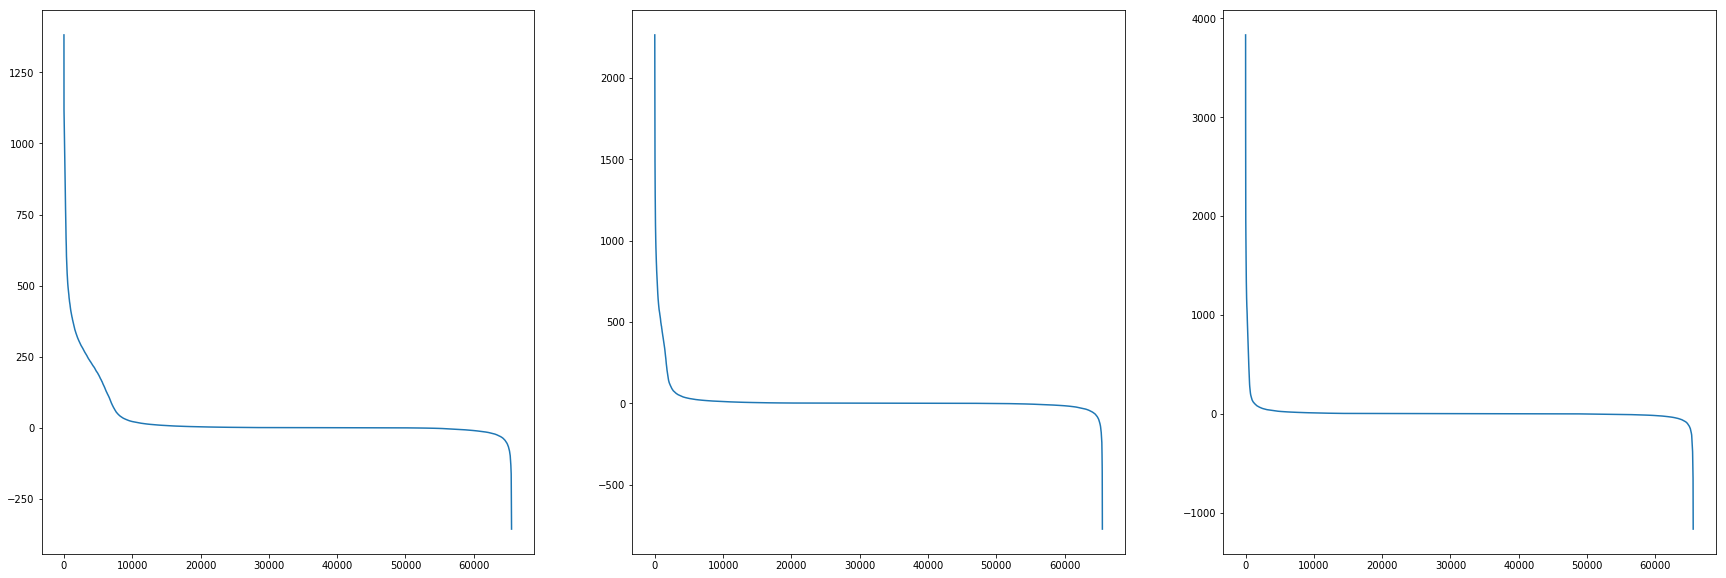

In [14]:
level1 = np.sort(dwt(1, X), axis = None)
level2 = np.sort(dwt(2, X), axis = None)
level3 = np.sort(dwt(3, X), axis = None)

x = np.array([range(len(level1)-1,-1,-1)]).reshape(level1.shape[0])

fig, ax = plt.subplots(1,3, figsize = (30,10))
ax[0].plot(x, level1)
ax[1].plot(x, level2)
ax[2].plot(x, level3)

Text(0, 0.5, 'Frobenius norm of approximation error')

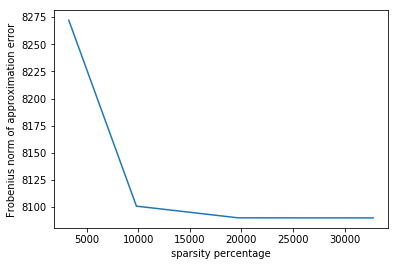

In [15]:
#Level 3 seems to have the fasest decay, so will go with that.
levels = 3

k1 = int(np.floor(.05*256**2)) #top 5%
k2 = int(np.floor(.15*256**2)) #top 15%
k3 = int(np.floor(.3*256**2)) #top 30%
k4 = int(np.floor(.5*256**2)) #top 50%

I1, W1, error1 = sparApprox(X, k1, levels)
I2, W2, error2 = sparApprox(X, k2, levels)
I3, W3, error3 = sparApprox(X, k3, levels)
I4, W4, error4 = sparApprox(X, k4, levels)

imagesc(I1, '5% sparse'), imagesc(I2, '15% sparse'), imagesc(I3, '30% sparse'), imagesc(I4, '50% sparse')

plt.plot([k1,k2,k3,k4], [error1, error2, error3, error4])
plt.xlabel('sparsity percentage')
plt.ylabel('Frobenius norm of approximation error')
